# 6.1 Stochastic Simulation Using ORCA 

In this example we will learn to do a stochastic Monte Carlo calculation for the band gap renormalization (similar to exercise 4.1). However, here our choice of ab initio code would be ORCA. As ORCA has routines that can efficiently calculate phonons; we will use it. 

As, usual the first step is to start with an guessed atomic cordinates and perform geometry optimizations. Then we take the geometry-optimized structure and perform frequency calculations that will give us the normal mode. These two steps can be performed at once using the following orca-input file: orca-opt-freq.inp (see orca manual: https://www.faccts.de/docs/orca/6.0/manual/ for mode details). 

In [1]:
%%bash
cat orca-opt-freq.inp

!B3LYP DEF2-TZVP OPT FREQ TIGHTSCF

%maxcore 28000

%pal nprocs 12 end

*xyzfile 0 1 co2-init.xyz


The calculation was submitted using orca-opt-freq.sbatch file to the midway3 cluster of RCC (University of Chicago). After finishing, orca would create several files.

The orca-opt-freq.hess file contains all information that we need. We would convert this file to PyEPFD restart xml file using a command line tool  avaiable at utils/orca. This command line tools takes 2 mandatory arguments  in the following order: (1) source path, i.e., the full path to the .hess file we would like to convert and (2) destination path, i.e., full path to the .xml file which we would like to obtain. Therefore we would use the fillowing command:

In [2]:
%run ../../../utils/orca/orca2pyepfd.py orca-opt-freq.hess co2.xml

                                                 
          ███████████                            
         ░░███░░░░░███                           
          ░███    ░███ █████ ████                
          ░██████████ ░░███ ░███                 
          ░███░░░░░░   ░███ ░███                 
          ░███         ░███ ░███                 
          █████        ░░███████                 
         ░░░░░          ░░░░░███                 
                        ███ ░███                 
                       ░░██████                  
                        ░░░░░░                   
 ██████████ ███████████  ███████████ ██████████  
░░███░░░░░█░░███░░░░░███░░███░░░░░░█░░███░░░░███ 
 ░███  █ ░  ░███    ░███ ░███   █ ░  ░███   ░░███
 ░██████    ░██████████  ░███████    ░███    ░███
 ░███░░█    ░███░░░░░░   ░███░░░█    ░███    ░███
 ░███ ░   █ ░███         ░███  ░     ░███    ███ 
 ██████████ █████        █████       ██████████  
░░░░░░░░░░ ░░░░░        ░░░░░       ░░░░░░░░░░   


The newly created co2.xml file is similar to that we saw before. As orca is a non-periodic code, while writing the cell values, PyEPFD puts a cubic cell with a large value (100 angstrom) of the cell parameter. If required, you can change it accordingly.  

In [3]:
%%bash
grep -A2 "<cell" co2.xml

  <cell shape='(6)'>
[  1.88972599e+02,  1.88972599e+02,  1.88972599e+02,  9.00000000e+01,  9.00000000e+01, 
   9.00000000e+01 ]


Now we will use the same mcap.py file that we used in exercise 4.1 to run the Monte Carlo simulation. Lets have a look again to this file.

In [ ]:
# %load ../4_stochastic/mcap.py
import sys,os
from pyepfd.coord_util import *
from pyepfd.pyepfd_io import *

#usage python3 mcap.py phonon_file T

phonon_file = sys.argv[1]
T = sys.argv[2]

sd_inp = read_pyepfd_info(file_path = phonon_file)

if sd_inp.ref_dynmatrix is not None:
    inp_dynmat = sd_inp.ref_dynmatrix
else:
    inp_dynmat = sd_inp.dynmatrix

# creating an xyz class to write the trajectory
sd_xyz = xyz(file_path=f'{T}K.xyz',io='w',atoms=sd_inp.atoms)

# Calling ionic mover class to perform Monte Carlo Antethetic Pair (MCAP) displacements
sdmoves = ionic_mover( atoms = sd_inp.atoms,
                       opt_coord = sd_inp.coord,
                       mode = 'SD',
                       algo ='mcap',
                       ngrid = 250,
                       dynmat = inp_dynmat,
                       asr = sd_inp.asr,
                       temperature = float(T))

for j in range(sdmoves.disp_coord.shape[1]):
    sd_xyz.write(cell = sd_inp.cell,coord = sdmoves.disp_coord[:,j])
del sd_xyz


we will run this file using co2.xml at 100 K using 5 mpi processes using the following command. 

In [4]:
%%bash
mpirun -np 5 python3 ../4_stochastic/mcap.py co2.xml 100

                                                 
          ███████████                            
         ░░███░░░░░███                           
          ░███    ░███ █████ ████                
          ░██████████ ░░███ ░███                 
          ░███░░░░░░   ░███ ░███                 
          ░███         ░███ ░███                 
          █████        ░░███████                 
         ░░░░░          ░░░░░███                 
                        ███ ░███                 
                       ░░██████                  
                        ░░░░░░                   
 ██████████ ███████████  ███████████ ██████████  
░░███░░░░░█░░███░░░░░███░░███░░░░░░█░░███░░░░███ 
 ░███  █ ░  ░███    ░███ ░███   █ ░  ░███   ░░███
 ░██████    ░██████████  ░███████    ░███    ░███
 ░███░░█    ░███░░░░░░   ░███░░░█    ░███    ░███
 ░███ ░   █ ░███         ░███  ░     ░███    ███ 
 ██████████ █████        █████       ██████████  
░░░░░░░░░░ ░░░░░        ░░░░░       ░░░░░░░░░░   


This will create 100K.xyz file containing the Monte Carlo trajectory. Remember, it will put the molecule within a 100 A cubic box. If you want to change it, change the cell parameters manually in the co2.xml file. 

In [5]:
%%bash
head 100K.xyz

3
# CELL(abcABC):  100.00000   100.00000   100.00000    90.00000    90.00000    90.00000  PyEPFD-Step: 0 positions{angstrom} cell{angstrom}
O      -0.0060215693      0.024954011        1.1515462
O      -0.0060215691      0.024954015       -1.1539117
C        0.016042212     -0.066480597     0.0031511087
3
# CELL(abcABC):  100.00000   100.00000   100.00000    90.00000    90.00000    90.00000  PyEPFD-Step: 1 positions{angstrom} cell{angstrom}
O       0.0060215737     -0.024954008        1.1683899
O       0.0060215735     -0.024954012       -1.1660242
C        -0.01604222      0.066480591    -0.0031512315


The next step would be to perform single-point orca calculations for each of these frames. We will do these calculations within a sub-directory MCAP_100K. Lets first create that. 

In [6]:
%%bash
mkdir MCAP_100K

To prepare inputs for single point orca calculations for each frame a command line tool: prepare_orca.py is available at /utils/orca directory of the PyEPFD distribution. This command line tool accepts 3 mandatory command line arguments in the following order:

(1) The xyz file, here it is 100K.xyz

(2) The index of the last frame upto which we want to perform orca calculations. In our 100K.xyz we have 500 frames. If we choose here a value of 400, then the inputs for first 400 frames would be created. For n-th frame a subdirectory named frame-n would be created, where the actual orca calculation would be performed. 

(3) We have to provide a dummy orca input file: orca-sp.inp for single-point calculations. This would be very similar to orca-opt-freq.inp file that we encountered before, except the "OPT", "FREQ" and "TIGHTSCF" options in the first line. Also we will add "EnGrad" so that ORCA computes forces. Note, unlike plane-wave codes, here forces are not free and often computationally expensive. Therefore, if not required (for example anharmonic measure), it is not recommended to compute forces. 
Also the xyz file name we changed to coord.xyz, i.e., within each frame-n directory a coord.xyz file would be created corresponding to the coordinates of the n-th frame. 

Let's have a look at the dummy orca input file:

In [7]:
%%bash
cat orca-sp.inp

!B3LYP DEF2-TZVP EnGrad

%maxcore 28000

%pal nprocs 12 end

*xyzfile 0 1 coord.xyz


Now lets run the prepare_orca.py within the directory MCAP_100K

In [8]:
%%bash
cd MCAP_100K/
../../../../utils/orca/prepare_orca.py ../100K.xyz 400 ../orca-sp.inp > prep_orca.log
cd ../

Let us have a look at the contents of the following directory.

In [9]:
%%bash
ls MCAP_100K/frame-1/

coord.xyz
orca-sp.inp


In [12]:
%%bash
echo "========coord.xyz========="
cat MCAP_100K/frame-1/coord.xyz
echo "=======orca-sp.inp========"
cat MCAP_100K/frame-1/orca-sp.inp

========coord.xyz=========
3
# CELL(abcABC):  100.00000   100.00000   100.00000    90.00000    90.00000    90.00000  PyEPFD-Step: 0 positions{angstrom} cell{angstrom}
O      -0.0060215693      0.024954011        1.1515462
O      -0.0060215691      0.024954015       -1.1539117
C        0.016042212     -0.066480597     0.0031511087
=======orca-sp.inp========
!B3LYP DEF2-TZVP EnGrad

%maxcore 28000

%pal nprocs 12 end

*xyzfile 0 1 coord.xyz


We see that geometry of the first frame and dummy orca input file has been copied within the frame-1 directory. From the MCAP_100K directory, we can submit the jobs using a job script similar to below:

In [ ]:
# %load MCAP_100K/orca.sbatch
#!/bin/bash
#SBATCH --account=pi-gagalli
#SBATCH -J co2
#SBATCH --time=24:00:00
#SBATCH --partition=gagalli-csl2
#SBATCH --qos=gagalli-csl2
#SBATCH --nodes=1
#SBATCH --ntasks-per-node=12
#SBATCH --mem-per-cpu=28GB
#SBATCH --cpus-per-task=1 #increase this comensurate with number of threads
#SBATCH --array=0-3
export nframe=100

#
# SET OMP_NUM_THREADS 
export OMP_NUM_THREADS=$SLURM_CPUS_PER_TASK
#
module load orca/5.0.4
orca=/software/orca-5.0.4-el8-x86_64/bin/orca
#
# NTASKS BELOW IS SET FOR GNU PARALLEL TO KNOW HOW MANY CORES IT HAS TO WORK WITH
NTASKS=$(($SLURM_NTASKS_PER_NODE * $SLURM_JOB_NUM_NODES))
echo "NTASKS IS $NTASKS"

start_time=$(date +%s)

# Calculating start and end frame indices from job array id.
let begin=${nframe}*${SLURM_ARRAY_TASK_ID}+1
let end=${nframe}*${SLURM_ARRAY_TASK_ID}+${nframe}

for (( i=$begin; i<=$end; i++ )); do
    cd frame-${i}
    ${orca} orca-sp.inp > orca-sp.out
    cd $SLURM_SUBMIT_DIR
done    

end_time=$(date +%s)
total_time=$((end_time - start_time))
echo "Total execution time: $total_time seconds"


The above script submit 4 array jobs handling frames: 1-100, 101-200, 201-300 and 301-400 respectively. Once all jobs are finished, we would extract the data using another command line tool extract_properties.py. The command line options can be obtained by using -h (or --help) options like below. 

In [1]:
%run ../../../utils/orca/extract_properties.py --help

                                                 
          ███████████                            
         ░░███░░░░░███                           
          ░███    ░███ █████ ████                
          ░██████████ ░░███ ░███                 
          ░███░░░░░░   ░███ ░███                 
          ░███         ░███ ░███                 
          █████        ░░███████                 
         ░░░░░          ░░░░░███                 
                        ███ ░███                 
                       ░░██████                  
                        ░░░░░░                   
 ██████████ ███████████  ███████████ ██████████  
░░███░░░░░█░░███░░░░░███░░███░░░░░░█░░███░░░░███ 
 ░███  █ ░  ░███    ░███ ░███   █ ░  ░███   ░░███
 ░██████    ░██████████  ░███████    ░███    ░███
 ░███░░█    ░███░░░░░░   ░███░░░█    ░███    ░███
 ░███ ░   █ ░███         ░███  ░     ░███    ███ 
 ██████████ █████        █████       ██████████  
░░░░░░░░░░ ░░░░░        ░░░░░       ░░░░░░░░░░   


Now we would extract various properies for frames 1 to 400. We extract degenerate HOMOs (orbital indices 9,10) and LUMO (orbital index 11). Therefore we use the following command.

In [2]:
%run ../../../utils/orca/extract_properties.py -p MCAP_100K/ -n 9:11 -f 1:400 -o orca-sp

Extracting properties from orca calculations
Frame range: (1, 400, 1)
40/400 frames processed in     1.638 s.
80/400 frames processed in     3.223 s.
120/400 frames processed in     5.089 s.
160/400 frames processed in     6.934 s.
200/400 frames processed in     8.545 s.
240/400 frames processed in     9.672 s.
280/400 frames processed in    10.186 s.
320/400 frames processed in    11.825 s.
360/400 frames processed in    13.378 s.

Property extraction finished in    14.846 s.
*************************************************
Total single-point energies are written at: 
   MCAP_100K//etotals.dat
Orbital energies are written at : 
   MCAP_100K//is_0_orb-9-11.dat
*************************************************
EnGrad informations are written at: 
   MCAP_100K//engrad.npz
Keywords for the engrad.npz file are:
   atoms   = a list of atoms symbols,
   frames  = a list of original frame indices,
   coords  = a 2D numpy of coordinates (au),
   forces  = a 2D numpy of forces (au),
   etotal

Like in example 4.1, we compute the band gap using an awk script.

In [3]:
%%bash
awk '{print $3-($1+$2)/2}' MCAP_100K/is_0_orb-9-11.dat | sed '1d' > gap.dat
head -n 25 gap.dat

10.0558
9.883
10.1485
10.313
10.4468
10.0803
10.1678
10.4725
10.3487
10.5374
10.5014
9.85465
9.73425
10.5914
10.4057
10.0914
10.6387
10.756
9.55225
10.3976
10.3003
10.2356
9.7635
10.2627
10.2915


As usual, to obtain the renormalized gap, the next step is to average over all 400 configurations.

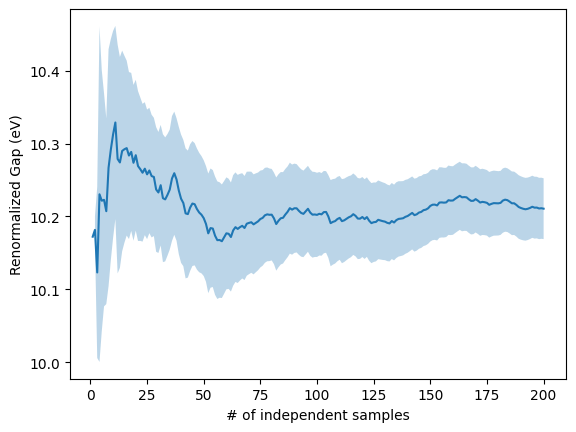

In [4]:
from pyepfd.epfd import mc_convergence
import matplotlib.pyplot as plt
co2_100K = mc_convergence(file_path='gap.dat',algo='mcap', usecols=(0))
mc = co2_100K.avg[:,0] #Our gap was in column 0 of the file
emc = 2*co2_100K.sd_mean[:,0] # Error is 2 times standard deviation of mean
plt.plot( [i+1 for i in range(len(mc))], mc, label='MC')
plt.fill_between([i+1 for i in range(len(mc))], mc + emc, mc - emc, alpha = 0.3)
plt.xlabel("# of independent samples")
plt.ylabel("Renormalized Gap (eV)")
plt.show()

Note, the result is different compared to what we obtained in exercise 4.1 because the band gap is dependent on the used basis set. Therefore, it should be repeated using larger and more accurate basis sets. 

Trajectory analysis, for example anharmonic measure can be computed using the following script

In [1]:
from pyepfd.anharm import anharm_measure
#We need pyepfd_io module to parse and store restart file
from pyepfd.pyepfd_io import *
#We need numpy to parse and process the energy.npz
import numpy as np

sd_inp = read_pyepfd_info(file_path='co2.xml')
if sd_inp.ref_dynmatrix is not None:
    inp_dynmat = sd_inp.ref_dynmatrix
else:
    inp_dynmat = sd_inp.dynmatrix

trajectory = np.load('MCAP_100K/engrad.npz')
coords = trajectory['coords']
forces = trajectory['forces']


# Now we calculate anharm measure
anharm = anharm_measure(dynmat = inp_dynmat, \
                        mass = sd_inp.mass, \
                        forces = forces, \
                        disp_coords = coords, \
                        opt_coord = sd_inp.coord, \
                        remove_rot_trans = True,\
                        asr = sd_inp.asr)

# We write the informations using write method in anharm object.
anharm.write(file_path='co2-100K-mcap',atoms=sd_inp.atoms)

# Task complete, we are deleting the anharm object to finish file writing
del anharm


                                                 
          ███████████                            
         ░░███░░░░░███                           
          ░███    ░███ █████ ████                
          ░██████████ ░░███ ░███                 
          ░███░░░░░░   ░███ ░███                 
          ░███         ░███ ░███                 
          █████        ░░███████                 
         ░░░░░          ░░░░░███                 
                        ███ ░███                 
                       ░░██████                  
                        ░░░░░░                   
 ██████████ ███████████  ███████████ ██████████  
░░███░░░░░█░░███░░░░░███░░███░░░░░░█░░███░░░░███ 
 ░███  █ ░  ░███    ░███ ░███   █ ░  ░███   ░░███
 ░██████    ░██████████  ░███████    ░███    ░███
 ░███░░█    ░███░░░░░░   ░███░░░█    ░███    ░███
 ░███ ░   █ ░███         ░███  ░     ░███    ███ 
 ██████████ █████        █████       ██████████  
░░░░░░░░░░ ░░░░░        ░░░░░       ░░░░░░░░░░   


This will create two files storing the mode-resolved and atom resolved anharmonic measures.

Let us first look at the mode-resolved measure.

In [2]:
%%bash
cat co2-100K-mcap_mode_res_anh_mes.out

# Mode  Freq(cm-1)       Var(Anh)        Var(Tot)     Anh_Measure 
#--------------------------------------------------------------
    1     -0.0120    0.000307268     5.89657e-05        2.28275 
    2      0.0001    0.000142152     2.67528e-06        7.28941 
    3      0.0006      0.0168978     3.86368e-07        209.129 
    4      0.0070    0.000306387     1.16596e-06        16.2104 
    5      0.0070    0.000141753      1.8682e-05        2.75457 
    6    676.4269      0.0176427     0.000183404        9.80794 
    7    676.4269     0.00120172     0.000475885         1.5891 
    8   1371.0021    0.000555802      0.00415696       0.365655 
    9   2408.0634      0.0373526       0.0142452         1.6193 
#--------------------------------------------------------------
# SUM                 0.00828314     0.00212703        1.97338


For the modes 6-9, we see similar trends as we have seen in exercise 4.1, i.e., higher anharmonic measure for bending modes and symmetric stretching has the lowest anharmonicity. However the obtained anharmonic measure is much larger. This is because, the forces are much more sensitive to the basis set and therefore to obtain force-based anharmonic measure, we need to repeat the whole calculation (starting from begining) with a much better basis set. 

We can also obtaine an energy based anharmonic measure (which is less sensitive); however here we will only get the total anharmonic measure and not the mode(atom) resolved anharmonic measure. For that purpose we can use the following script. 

In [1]:
from pyepfd.anharm import boltzmann_reweighting
#We need pyepfd_io module to parse and store restart file
from pyepfd.pyepfd_io import *
from pyepfd.coord_util import xyz
#We need numpy to parse and process the energy.npz
import numpy as np

sd_inp = read_pyepfd_info(file_path='co2.xml')
if sd_inp.ref_dynmatrix is not None:
    inp_dynmat = sd_inp.ref_dynmatrix
else:
    inp_dynmat = sd_inp.dynmatrix

# This can be calculated even when engrad.npz file is not present
disp_energy = np.genfromtxt('MCAP_100K/etotals.dat')
# We are loading the original trajectory
trajectory = xyz(file_path='100K.xyz',io='r')
n_frames = len(disp_energy)
# below we assume only first n_frames are extracted in the previous step
coords = trajectory.coords[:n_frames]

#We need the energy of the optimized geometry in Hatree
# which we obtain from the orca-opt-freq.engrad file
opt_energy = -188.587352098676

# Now we calculate anharm measure
anharm = boltzmann_reweighting(dynmat = inp_dynmat, \
                        mass = sd_inp.mass, \
                        disp_coords = coords, \
                        opt_coord = sd_inp.coord, \
                        opt_energy = opt_energy,
                        disp_energy = disp_energy,       
                        remove_rot_trans = True,\
                        asr = sd_inp.asr,
                        temperature = 100)

# We write the informations using write method in anharm object.
print(f"Total anharmonic measure (Energy based) = {anharm.anharm_measure}")

# Task complete, we are deleting the anharm object to finish file writing
del anharm

                                                 
          ███████████                            
         ░░███░░░░░███                           
          ░███    ░███ █████ ████                
          ░██████████ ░░███ ░███                 
          ░███░░░░░░   ░███ ░███                 
          ░███         ░███ ░███                 
          █████        ░░███████                 
         ░░░░░          ░░░░░███                 
                        ███ ░███                 
                       ░░██████                  
                        ░░░░░░                   
 ██████████ ███████████  ███████████ ██████████  
░░███░░░░░█░░███░░░░░███░░███░░░░░░█░░███░░░░███ 
 ░███  █ ░  ░███    ░███ ░███   █ ░  ░███   ░░███
 ░██████    ░██████████  ░███████    ░███    ░███
 ░███░░█    ░███░░░░░░   ░███░░░█    ░███    ░███
 ░███ ░   █ ░███         ░███  ░     ░███    ███ 
 ██████████ █████        █████       ██████████  
░░░░░░░░░░ ░░░░░        ░░░░░       ░░░░░░░░░░   


We can see that the energy-based total anharmonic measure is much more consistent with the one we obtained in exercise 4.1. Note, for larges sytems and basis sets, force-calculations have significant computational overload. Therefore, while using localized basis set, it is recommended to use energy-based anharmonic measure. 